<img src="logo completo.png" width="1200" height="400">

# Tarea 5 prediccion compañia Nintendo.

In [15]:
import tensorflow as tf

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#%matplotlib widget

from sklearn.preprocessing import MinMaxScaler

#setting figure size
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 20,10


# importa objetos de keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, LSTM, Bidirectional
print("Versión de Tensorflow: ", tf.__version__)

# optimizador
from tensorflow.keras.optimizers import Adam, Adamax

# Callbacks
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

Versión de Tensorflow:  2.12.0


     ---------------------------------------- 62.5/62.5 kB 1.6 MB/s eta 0:00:00
     -------------------------------------- 112.2/112.2 kB 3.3 MB/s eta 0:00:00
     -------------------------------------- 502.3/502.3 kB 4.5 MB/s eta 0:00:00
  Attempting uninstall: pytz
    Found existing installation: pytz 2022.1
    Uninstalling pytz-2022.1:
      Successfully uninstalled pytz-2022.1


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
conda-repo-cli 1.0.20 requires clyent==1.2.1, but you have clyent 1.2.2 which is incompatible.
conda-repo-cli 1.0.20 requires nbformat==5.4.0, but you have nbformat 5.5.0 which is incompatible.


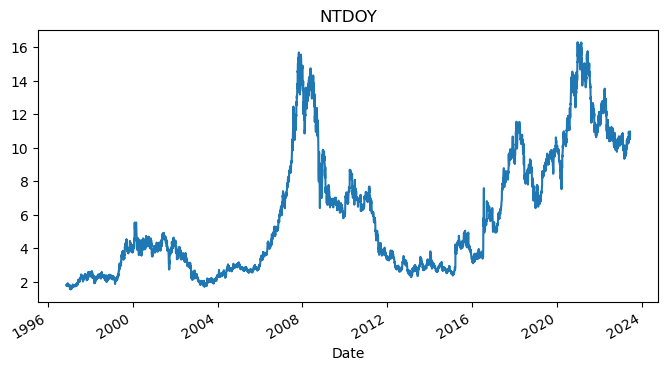

In [4]:
!pip install yfinance
import yfinance as yf
# Define Stock
stock = 'NTDOY'

# Get data
data = yf.download(tickers=stock, period='max', interval='1d', progress=False)

#Print data
#display(data)

#Plot data
plt.close('all')
plt.figure(figsize=(8,4))
data['Open'].plot(title=stock);

In [6]:
#reading from a local file
data_raw = pd.read_csv('NTDOY.csv')

In [7]:
data_raw

,Date,Open,High,Low,Close,Adj Close,Volume
0,1996-11-18,1.8000,1.800,1.7250,1.8000,1.710279,406500
1,1996-11-19,1.8000,1.800,1.7250,1.8000,1.710279,690500
2,1996-11-20,1.8125,1.850,1.7000,1.8125,1.722156,280000
3,1996-11-21,1.8000,1.825,1.7125,1.8000,1.710279,458500
4,1996-11-22,1.8250,1.850,1.7500,1.8250,1.734033,1000500
...,...,...,...,...,...,...,...
6629,2023-03-23,9.6600,9.670,9.5900,9.6400,9.640000,597300
6630,2023-03-24,9.7700,9.770,9.5700,9.6000,9.600000,676800
6631,2023-03-27,9.7200,9.740,9.6000,9.6500,9.650000,605400
6632,2023-03-28,9.7000,9.700,9.5500,9.6100,9.610000,707800


In [8]:
#Extrae datos para la serie que se desea predecir-close 

#creating dataframe with date and the target variable
data_raw['Date'] = pd.to_datetime(data_raw.Date,format='%Y-%m-%d')
# Change index for datetime index
data_raw.index = data_raw['Date']
#Order if neccesary
data_raw.sort_index(ascending=True, inplace=True)
# Get only what you want
data = pd.DataFrame(data_raw[['Date', 'Close']])

#setting index
data.index = data.Date
# Drop Date
data.drop('Date', axis=1, inplace=True)
#Show Data
print (data.head()
,data.tail())

             Close
Date              
1996-11-18  1.8000
1996-11-19  1.8000
1996-11-20  1.8125
1996-11-21  1.8000
1996-11-22  1.8250             Close
Date             
2023-03-23   9.64
2023-03-24   9.60
2023-03-27   9.65
2023-03-28   9.61
2023-03-29   9.77


In [9]:
# plot
len_data = len(data)
len_train = int(len_data*0.9) # 90%  = 9479 -> Depende de la fecha y acción elegida 
len_test = len_data - len_train # 10% = 1054 -> Depende de la fecha y acción elegida 
print (len_data, '=', len_train, '+',len_test)

6634 = 5970 + 664


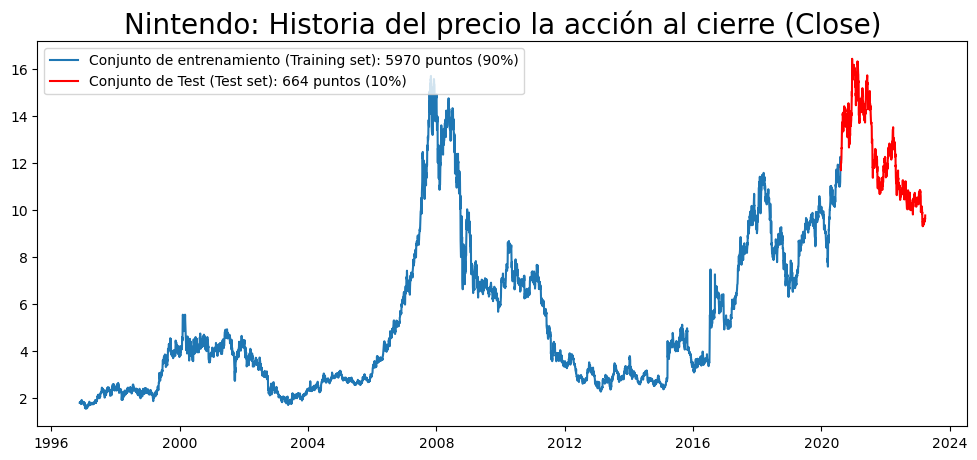

In [10]:
plt.figure(figsize=(12,5))
plt.plot(data[:len_train], label='Conjunto de entrenamiento (Training set): {} puntos (90%)'.format(len_train))
plt.plot(data['Close'][len_train:], label='Conjunto de Test (Test set): {} puntos (10%)'.format(len_test), color='r') 
plt.title("Nintendo: Historia del precio la acción al cierre (Close)", size = 20)
plt.legend()
plt.show()

## Preparación de los datos para el entrenamiento de la red LSTM
Para evitar problemas con las tendencias y para mejorar la estimación (entrenamiento) los datos se van a transformar a la escala 
. Para las predicciones se utiliza la transformación inversa.

Primero extrae los valores y se crea el objeto MinMaxScaler (vamos a reescalar todos los datos no solo los de entrenamiento)

In [16]:
#creating train and test sets
dataset = data.values

# create the scaler object and scale the data
scaler = MinMaxScaler(feature_range=(0,1))
# Scaled data
dataset = np.squeeze(np.array(scaler.fit_transform(dataset)),axis=1)
dataset = dataset.astype(float)
dataset


array([0.01680108, 0.01680108, 0.01764113, ..., 0.54435484, 0.54166667,
       0.55241935])

In [17]:
# Check ok
print(dataset.shape)
# Check ok in scaler
print(f'\nMin: {min(dataset)}, Max: {max(dataset)}')

(6634,)

Min: 0.0, Max: 1.0


Crea datos de entrenamiento
La red LSTM tendrá como entrada "time_step" datos consecutivos, y como salida 1 dato (la predicción a partir de esos "time_step" datos se hace para el siguiente día).

Se conformará de esta forma el set de entrenamiento

Número de datos consecutivos para entrenamiento: time_step = 60.
Días a predecir: days = 1
Función para crear los datos entrenamiento

In [18]:
def univariate_data(dataset, start_index, end_index, history_size, target_size):
    ''' dataset: conjunto de datos en forma de array
        start_index: índice inicial de donde empezar a tomar los datos
        end_index: índice final para tomar los datos. None para tomarlos todos
        history_size: tamaño de la ventana para crear las secuencias
        target_size: dentro de cuántas observaciones futuras desea pronosticar
    '''  
    data = []
    labels = []
    
    # Empezamos desfasados para tomar desde el incio de la serie
    start_index = start_index + history_size
    if end_index is None:
        # El último índice a tomar debe dejar espacio para el tamaño de la ventana
        end_index = len(dataset)

    for i in range(start_index, end_index-target_size+1):
        indices = range(i-history_size, i)
        # Reshape data from (history_size,) to (history_size, 1)
        data.append(np.reshape(dataset[indices], (history_size, 1)))
        # Etiquetas (Datos a predecir)
        labels.append(dataset[i+target_size-1])

    return np.array(data), np.array(labels)

In [19]:
# hiperparámetros para crear las secuencias
past_history = 60 # tamaño secuencias de entrada (Ventana de tiempo)
future_target = 1 # días adelante
TRAIN_SPLIT = len_train # nuḿero de datos entrenamiento

# secuencias de entrenamiento
X_train, y_train = univariate_data(dataset, start_index=0, 
                                            end_index=TRAIN_SPLIT,
                                            history_size=past_history,
                                            target_size=future_target)
#secuencias de test
# No se usará ningún dato que el modelo haya visto
X_test, y_test = univariate_data(dataset, TRAIN_SPLIT-past_history-future_target+1, None,
                                          past_history,
                                          future_target)

print(TRAIN_SPLIT)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

5970
(5910, 60, 1)
(5910,)
(664, 60, 1)
(664,)


In [20]:
# Visualize
train_df = pd.DataFrame(X_train[...,0], columns=[f'h_{i}' for i in range(past_history)])
pd.concat((train_df,pd.DataFrame(y_train, columns=['target'])),axis=1)

,h_0,h_1,h_2,h_3,h_4,h_5,h_6,h_7,h_8,h_9,...,h_51,h_52,h_53,h_54,h_55,h_56,h_57,h_58,h_59,target
0,0.016801,0.016801,0.017641,0.016801,0.018481,0.018481,0.020161,0.020161,0.017641,0.013441,...,0.003360,0.010081,0.003360,0.003360,0.003360,0.006720,0.001680,0.006720,0.006720,0.005670
1,0.016801,0.017641,0.016801,0.018481,0.018481,0.020161,0.020161,0.017641,0.013441,0.015121,...,0.010081,0.003360,0.003360,0.003360,0.006720,0.001680,0.006720,0.006720,0.005670,0.008401
2,0.017641,0.016801,0.018481,0.018481,0.020161,0.020161,0.017641,0.013441,0.015121,0.016801,...,0.003360,0.003360,0.003360,0.006720,0.001680,0.006720,0.006720,0.005670,0.008401,0.006720
3,0.016801,0.018481,0.018481,0.020161,0.020161,0.017641,0.013441,0.015121,0.016801,0.018481,...,0.003360,0.003360,0.006720,0.001680,0.006720,0.006720,0.005670,0.008401,0.006720,0.010081
4,0.018481,0.018481,0.020161,0.020161,0.017641,0.013441,0.015121,0.016801,0.018481,0.020161,...,0.003360,0.006720,0.001680,0.006720,0.006720,0.005670,0.008401,0.006720,0.010081,0.008401
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5905,0.626344,0.592070,0.583871,0.592339,0.596102,0.598387,0.600000,0.602957,0.582661,0.590054,...,0.641667,0.638441,0.635081,0.638575,0.656586,0.649328,0.660081,0.653495,0.635215,0.647984
5906,0.592070,0.583871,0.592339,0.596102,0.598387,0.600000,0.602957,0.582661,0.590054,0.594489,...,0.638441,0.635081,0.638575,0.656586,0.649328,0.660081,0.653495,0.635215,0.647984,0.662634
5907,0.583871,0.592339,0.596102,0.598387,0.600000,0.602957,0.582661,0.590054,0.594489,0.596505,...,0.635081,0.638575,0.656586,0.649328,0.660081,0.653495,0.635215,0.647984,0.662634,0.685349
5908,0.592339,0.596102,0.598387,0.600000,0.602957,0.582661,0.590054,0.594489,0.596505,0.586022,...,0.638575,0.656586,0.649328,0.660081,0.653495,0.635215,0.647984,0.662634,0.685349,0.720027


In [21]:
print(dataset[:61].shape)
dataset[:61]

(61,)


array([0.01680108, 0.01680108, 0.01764113, 0.01680108, 0.01848118,
       0.01848118, 0.02016129, 0.02016129, 0.01764113, 0.01344086,
       0.01512097, 0.01680108, 0.01848118, 0.02016129, 0.02100134,
       0.02520161, 0.0218414 , 0.02016129, 0.01512097, 0.02016129,
       0.02016129, 0.01848118, 0.01848118, 0.02016129, 0.01512097,
       0.02016129, 0.01848118, 0.01848118, 0.01848118, 0.01848118,
       0.01848118, 0.01680108, 0.01512097, 0.01848118, 0.01176075,
       0.01512097, 0.0109207 , 0.01680108, 0.01512097, 0.00840054,
       0.00168011, 0.00168011, 0.00336022, 0.00504032, 0.00504032,
       0.00336022, 0.00840054, 0.00504032, 0.        , 0.00336022,
       0.00336022, 0.00336022, 0.01008065, 0.00336022, 0.00336022,
       0.00336022, 0.00672043, 0.00168011, 0.00672043, 0.00672043,
       0.00567036])

In [22]:
test_df = pd.DataFrame(X_test[...,0], columns=[f'h_{i}' for i in range(past_history)])
pd.concat((test_df,pd.DataFrame(y_test, columns=['target'])),axis=1)

,h_0,h_1,h_2,h_3,h_4,h_5,h_6,h_7,h_8,h_9,...,h_51,h_52,h_53,h_54,h_55,h_56,h_57,h_58,h_59,target
0,0.598387,0.600000,0.602957,0.582661,0.590054,0.594489,0.596505,0.586022,0.584946,0.584005,...,0.649328,0.660081,0.653495,0.635215,0.647984,0.662634,0.685349,0.720027,0.690591,0.692204
1,0.600000,0.602957,0.582661,0.590054,0.594489,0.596505,0.586022,0.584946,0.584005,0.579167,...,0.660081,0.653495,0.635215,0.647984,0.662634,0.685349,0.720027,0.690591,0.692204,0.681452
2,0.602957,0.582661,0.590054,0.594489,0.596505,0.586022,0.584946,0.584005,0.579167,0.592204,...,0.653495,0.635215,0.647984,0.662634,0.685349,0.720027,0.690591,0.692204,0.681452,0.703226
3,0.582661,0.590054,0.594489,0.596505,0.586022,0.584946,0.584005,0.579167,0.592204,0.576613,...,0.635215,0.647984,0.662634,0.685349,0.720027,0.690591,0.692204,0.681452,0.703226,0.701613
4,0.590054,0.594489,0.596505,0.586022,0.584946,0.584005,0.579167,0.592204,0.576613,0.587366,...,0.647984,0.662634,0.685349,0.720027,0.690591,0.692204,0.681452,0.703226,0.701613,0.701747
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
659,0.602823,0.595430,0.592742,0.603495,0.596102,0.601478,0.592742,0.588038,0.596102,0.598790,...,0.530914,0.531586,0.530914,0.527554,0.535618,0.540995,0.537634,0.538306,0.534274,0.543683
660,0.595430,0.592742,0.603495,0.596102,0.601478,0.592742,0.588038,0.596102,0.598790,0.591398,...,0.531586,0.530914,0.527554,0.535618,0.540995,0.537634,0.538306,0.534274,0.543683,0.540995
661,0.592742,0.603495,0.596102,0.601478,0.592742,0.588038,0.596102,0.598790,0.591398,0.584005,...,0.530914,0.527554,0.535618,0.540995,0.537634,0.538306,0.534274,0.543683,0.540995,0.544355
662,0.603495,0.596102,0.601478,0.592742,0.588038,0.596102,0.598790,0.591398,0.584005,0.594086,...,0.527554,0.535618,0.540995,0.537634,0.538306,0.534274,0.543683,0.540995,0.544355,0.541667


In [23]:
print(dataset[-61:].shape)
dataset[-61:]

(61,)


array([0.59610215, 0.60147849, 0.59274194, 0.58803763, 0.59610215,
       0.59879032, 0.59139785, 0.58400538, 0.59408602, 0.59811828,
       0.61895161, 0.61895161, 0.61760753, 0.61760753, 0.61223118,
       0.61021505, 0.61491935, 0.62365591, 0.625     , 0.61693548,
       0.61962366, 0.62298387, 0.62096774, 0.61827957, 0.60685484,
       0.57997312, 0.56182796, 0.5672043 , 0.57258065, 0.56317204,
       0.56518817, 0.56586022, 0.57862903, 0.57862903, 0.56854839,
       0.5577957 , 0.56182796, 0.54032258, 0.52956989, 0.52284946,
       0.52150538, 0.52553763, 0.53629032, 0.52755376, 0.52419355,
       0.52755376, 0.52822581, 0.53091398, 0.53158602, 0.53091398,
       0.52755376, 0.53561828, 0.54099462, 0.53763441, 0.53830645,
       0.53427419, 0.5436828 , 0.54099462, 0.54435484, 0.54166667,
       0.55241935])

In [24]:
#Crea el modelo LSTM
# shapes
input_shape = (X_train.shape[1], X_train.shape[2])
units = 50 #tamaño de salida del lstm oculto

# layers
inputs = Input(input_shape)
x = Dropout(0.2, name= 'Dropout_01')(inputs) #no usa el 0.2 
x = LSTM(units=units, name='LSTM_layer')(x)
#x = LSTM(units=units, return_sequences=True,name='LSTM_layer')(inputs)
#x = Dropout(0.4)
#x = LSTM(units=units//2, name='LSTM_layer_2')(x)
#x = Dropout(0.4)
x = Dropout(0.2, name= 'Dropout_02')(x)
outputs = Dense(1)(x)

# model
model_01 = Model(inputs=inputs, outputs=outputs, name='series_LSTM_model')
model_01.summary()

Model: "series_LSTM_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 60, 1)]           0         
                                                                 
 Dropout_01 (Dropout)        (None, 60, 1)             0         
                                                                 
 LSTM_layer (LSTM)           (None, 50)                10400     
                                                                 
 Dropout_02 (Dropout)        (None, 50)                0         
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 10,451
Trainable params: 10,451
Non-trainable params: 0
_________________________________________________________________


In [25]:
#Callbacks
import os
os.makedirs(f'G:/Mi unidad/2023-1/Inteligencia Artificial/tarea5/checkpoints/{future_target}_dia', exist_ok=True)

checkpoint_filepath = f'../Checkpoints/{future_target}_dia'
checkpoint_callback = ModelCheckpoint(
 filepath=checkpoint_filepath,
 save_weights_only=False,
 monitor="val_loss",
 mode="min",
 save_best_only=True)

early_stopping_callback = EarlyStopping(
 monitor="val_loss",
 min_delta=0.005,
 patience=20,
 mode="min",
 restore_best_weights=False
)

rlrop_callback = ReduceLROnPlateau(monitor='val_loss', factor=0.2, mode='min', patience=5, min_lr=0.0001)

In [26]:
#Compila
#Se usará el optimizador Adam y la función de pérdida MSE

model_01.compile(loss='mean_squared_error', optimizer=Adam())

In [27]:
#Entrena el modelo
epochs=30

history = model_01.fit(
    X_train, y_train,
    epochs=epochs,
    batch_size=32,
    validation_split=0.1,
    verbose=1,
    shuffle=True,
    callbacks=[early_stopping_callback, checkpoint_callback, rlrop_callback]
)

Epoch 1/30
166/167 [============================>.] - ETA: 0s - loss: 0.0078

INFO:tensorflow:Assets written to: ../Checkpoints\1_dia\assets


INFO:tensorflow:Assets written to: ../Checkpoints\1_dia\assets


167/167 [==============================] - 18s 86ms/step - loss: 0.0078 - val_loss: 0.0011 - lr: 0.0010
Epoch 2/30
167/167 [==============================] - 7s 42ms/step - loss: 0.0023 - val_loss: 0.0025 - lr: 0.0010
Epoch 3/30
166/167 [============================>.] - ETA: 0s - loss: 0.0021

INFO:tensorflow:Assets written to: ../Checkpoints\1_dia\assets


INFO:tensorflow:Assets written to: ../Checkpoints\1_dia\assets


167/167 [==============================] - 16s 97ms/step - loss: 0.0021 - val_loss: 0.0011 - lr: 0.0010
Epoch 4/30
167/167 [==============================] - 6s 33ms/step - loss: 0.0020 - val_loss: 0.0011 - lr: 0.0010
Epoch 5/30
167/167 [==============================] - 6s 34ms/step - loss: 0.0019 - val_loss: 0.0011 - lr: 0.0010
Epoch 6/30
167/167 [==============================] - 6s 37ms/step - loss: 0.0018 - val_loss: 0.0015 - lr: 0.0010
Epoch 7/30
167/167 [==============================] - ETA: 0s - loss: 0.0017

INFO:tensorflow:Assets written to: ../Checkpoints\1_dia\assets


INFO:tensorflow:Assets written to: ../Checkpoints\1_dia\assets


167/167 [==============================] - 12s 70ms/step - loss: 0.0017 - val_loss: 0.0011 - lr: 2.0000e-04
Epoch 8/30
167/167 [==============================] - 6s 35ms/step - loss: 0.0017 - val_loss: 0.0012 - lr: 2.0000e-04
Epoch 9/30
167/167 [==============================] - 6s 35ms/step - loss: 0.0016 - val_loss: 0.0011 - lr: 2.0000e-04
Epoch 10/30
167/167 [==============================] - 6s 38ms/step - loss: 0.0017 - val_loss: 0.0011 - lr: 2.0000e-04
Epoch 11/30
167/167 [==============================] - 6s 34ms/step - loss: 0.0017 - val_loss: 0.0018 - lr: 2.0000e-04
Epoch 12/30
167/167 [==============================] - 6s 34ms/step - loss: 0.0016 - val_loss: 0.0011 - lr: 1.0000e-04
Epoch 13/30
167/167 [==============================] - 7s 42ms/step - loss: 0.0016 - val_loss: 0.0011 - lr: 1.0000e-04
Epoch 14/30
167/167 [==============================] - 8s 48ms/step - loss: 0.0016 - val_loss: 0.0017 - lr: 1.0000e-04
Epoch 15/30
167/167 [==============================] - 8s 47m

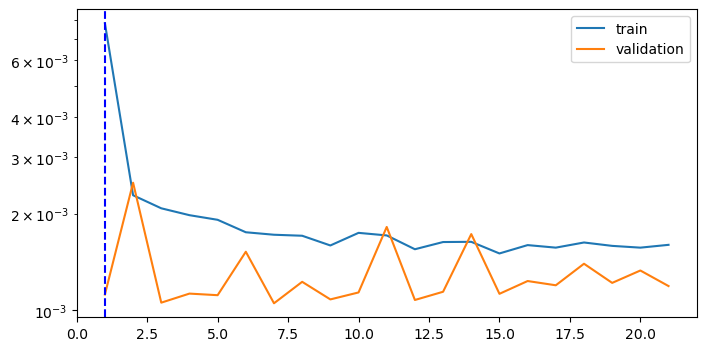

In [28]:
#Plot data
plt.close('all')
plt.figure(figsize=(8,4))
plt.semilogy(range(1, history.epoch[-1]+2),history.history['loss'], label='train')
plt.semilogy(range(1, history.epoch[-1]+2),history.history['val_loss'], label='validation')
plt.axvline(x = 1, linestyle='--', color = 'b')
plt.legend();

In [31]:
# Ruta y nombre de archivo para guardar el modelo
model_filename = 'modelo_entrenado.h5'

# Guardar el modelo
model_01.save(model_filename)

In [32]:
from tensorflow.keras.models import load_model

# Cargar el modelo
loaded_model = load_model(model_filename)

## Predicciones
Prepara los datos de validación

In [29]:
X_test.shape

(664, 60, 1)

In [35]:
# Evaluar el modelo en los datos de prueba
evaluation = loaded_model.evaluate(X_test, y_test, verbose=1)

# Obtener los resultados de pérdida y precisión
loss = evaluation
accuracy = evaluation

# Imprimir los resultados
print("Pérdida en los datos de prueba:", loss)
print("Precisión en los datos de prueba:", accuracy)

21/21 [==============================] - 0s 19ms/step - loss: 0.0028
Pérdida en los datos de prueba: 0.0027944177854806185
Precisión en los datos de prueba: 0.0027944177854806185


In [37]:
# Obtener la pérdida y precisión del historial de entrenamiento
train_loss = history.history['loss']
train_accuracy = history.history['accuracy']
val_loss = history.history['val_loss']
val_accuracy = history.history['val_accuracy']

# Crear la gráfica
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss on Test Data')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy on Test Data')
plt.legend()

plt.tight_layout()
plt.show()

KeyError: 'accuracy'

In [ ]:
#Regreso a la escala original
y_pred_or1 = scaler.inverse_transform(y_pred_p1.reshape(-1,1))
y_test_or1 = scaler.inverse_transform(y_test_p1.reshape(-1,1))
k=0
for i,j in zip(y_test_or1, y_pred_or1):
    print (i,j, i-j)
    k+=1
    if k==10:
        break

[11.85] [11.356507] [0.4934927]
[11.69] [11.3967] [0.29330009]
[12.014] [11.425284] [0.58871561]
[11.99] [11.470022] [0.5199778]
[11.992] [11.511205] [0.48079528]
[12.184] [11.550608] [0.63339232]
[12.61] [11.598665] [1.01133476]
[12.64] [11.669149] [0.9708506]
[12.62] [11.739935] [0.88006508]
[12.862] [11.807672] [1.05432845]


In [ ]:
rmsLSTM = np.sqrt(np.mean(np.power(y_pred_or1-y_test_or1,2)))
print(rmsLSTM )

0.5961497309919704


In [ ]:

y_pred_or1.shape

(664, 1)

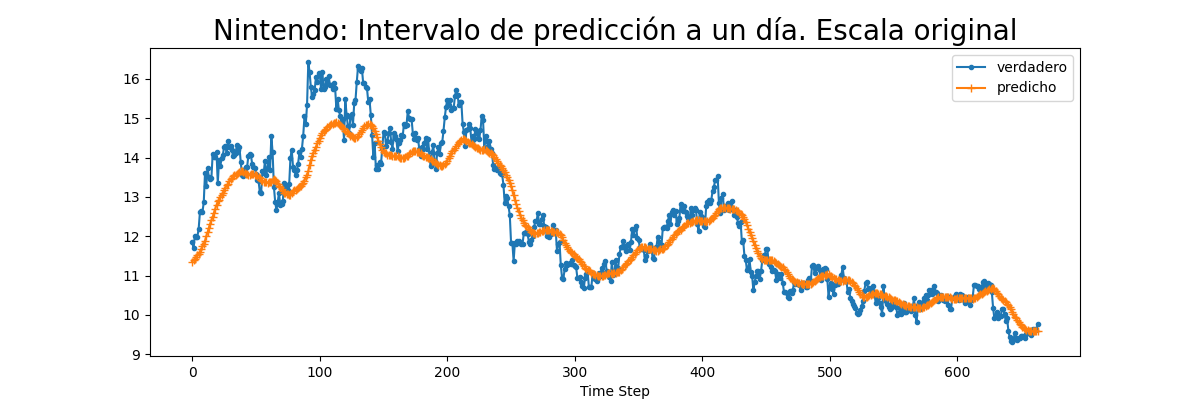

In [ ]:
plt.close('all')
plt.figure(figsize=(12,4))
plt.plot(np.arange(0, len(y_test_or1)), y_test_or1, marker='.', label="verdadero")
plt.plot(np.arange(0, len(y_pred_or1)), y_pred_or1, marker='+', label="predicho")
plt.xlabel('Time Step')

plt.annotate("modelo = LSTM(50), timestep=60" , xy=(100, 146), size = 15)
plt.annotate(f"epochs = {history.epoch[-1]}" , xy=(100, 126), size = 15)
plt.annotate("rms = "+str(round(rmsLSTM,2)) , xy=(100, 106), size = 15)
plt.title("Nintendo: Intervalo de predicción a un día. Escala original", size = 20)
plt.legend()
plt.show();

### Guarda el modelo entrenado

In [155]:
model_01.save(f'../Modelos/modelo_{stock}_{future_target}_dia.h5')

In [156]:
#Intervalos de predicción. TO DO
#Recupera la configuración del modelo
print(model_01.get_config())

{'name': 'series_LSTM_model', 'layers': [{'class_name': 'InputLayer', 'config': {'batch_input_shape': (None, 60, 1), 'dtype': 'float32', 'sparse': False, 'ragged': False, 'name': 'input_6'}, 'name': 'input_6', 'inbound_nodes': []}, {'class_name': 'Dropout', 'config': {'name': 'Dropout_01', 'trainable': True, 'dtype': 'float32', 'rate': 0.2, 'noise_shape': None, 'seed': None}, 'name': 'Dropout_01', 'inbound_nodes': [[['input_6', 0, 0, {}]]]}, {'class_name': 'LSTM', 'config': {'name': 'LSTM_layer', 'trainable': True, 'dtype': 'float32', 'return_sequences': False, 'return_state': False, 'go_backwards': False, 'stateful': False, 'unroll': False, 'time_major': False, 'units': 50, 'activation': 'tanh', 'recurrent_activation': 'sigmoid', 'use_bias': True, 'kernel_initializer': {'class_name': 'GlorotUniform', 'config': {'seed': None}, 'shared_object_id': 2}, 'recurrent_initializer': {'class_name': 'Orthogonal', 'config': {'gain': 1.0, 'seed': None}, 'shared_object_id': 3}, 'bias_initializer': 

### Predicción para Mañana

In [158]:
from datetime import date
hoy = data.index[-past_history:][-1]
print("Hoy: ", hoy)

Hoy:  2023-03-29 00:00:00


In [160]:
mañana = data.index[-past_history:][-1]+pd.DateOffset(1)
print("Mañana: ", mañana) 

Mañana:  2023-03-30 00:00:00


In [161]:
ultima_ventana = dataset[-past_history:]

ultima_ventana_tensor = np.reshape(dataset[-past_history:], (1,past_history, 1))

# predictions
prediction1 = model_01.predict(ultima_ventana_tensor)

# Escalas originales
ultima_ventana_or = scaler.inverse_transform(ultima_ventana.reshape(-1,1))
prediction_or = scaler.inverse_transform(prediction1)[0]

1/1 [==============================] - 0s 226ms/step


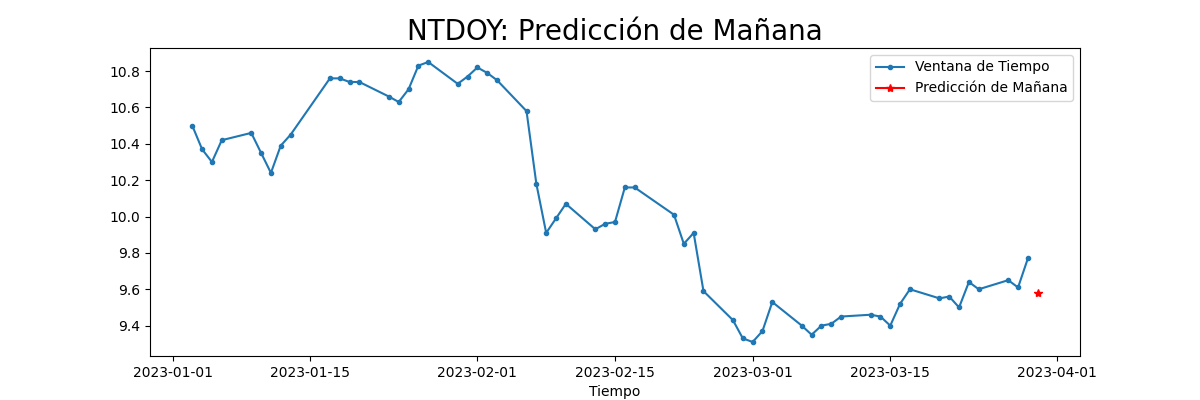

In [163]:
plt.close('all')
plt.figure(figsize=(12,4))
plt.plot(data.index[-past_history:], ultima_ventana_or, marker='.', label="Ventana de Tiempo")
plt.plot(mañana, prediction_or, marker='*', label="Predicción de Mañana", color='r')
plt.xlabel('Tiempo')

plt.title(f"{stock}: Predicción de Mañana", size = 20)
plt.legend()
plt.show();